# A time Story of offshore Societies

You can see the aim of this project in the README file.

Our work is based on 4 databases, namely the *bahamas leaks*, the *panama papers*, the *offshore leaks* and the *paradise papers*. They all contain csv files with all the data of a graph : nodes (one file for each type of node), and edges. We merged all these files in this notebook.

You will see all the steps of our data exploration. In the end our objective is to arrive to two Dataframe, one containing all the nodes and the relevant information, and one containing the edges with relevant information.

## Imports

In [1]:
import pandas as pd
import numpy as np
import networkx as nx #For graphs
import copy
import warnings
from datetime import *
import dateutil.parser
warnings.filterwarnings("ignore")
import folium
import json
from folium import IFrame
import base64

import matplotlib.pyplot as plt

# https://www.occrp.org/en/panamapapers/database
# TRUMP OFFSHORE INC. is good example to see all entities interacting

## Filenames / paths

The data is separated for every leak source. For each leak source there is a folder containing the nodes of the graph, that can be of different types : <i>intermediary, officer, entity, address</i> (and <i>other</i> for paradise papers only). The folder also contains the edges of this graph.

In [2]:
bahamas_folder = "bahamas/"
panama_folder = "panama/"
paradise_folder = "paradise/"
offshore_folder = "offshore/"

sources_names = ['bahamas', 'panama', 'paradise', 'offshore']

panama_name = panama_folder + "panama_papers"
paradise_name = paradise_folder + "paradise_papers"
offshore_name = offshore_folder + "offshore_leaks"
bahamas_name = bahamas_folder + "bahamas_leaks"

edges_name = ".edges"
nodes_name = ".nodes."

address_name = "address"
intermediary_name = "intermediary"
officer_name = "officer"
entity_name = "entity"
others_name = "other" # Only for paradise paper there is this extra entity

usual_entity_names = [address_name, intermediary_name, officer_name, entity_name]

## Build local storage

We store data in dictionnaries that map each leak source to its content, which is a dictionnary that maps each type of entity to the Dataframe containing its values. For example <b>d_sources["bahamas"]["officer"]</b> is the Dataframe of officers coming from the bahamas leaks.

In [3]:
def my_read_csv(filename) :
    """ To have same rules when reading data from csv """
    return pd.read_csv(filename, dtype = str)

def build_dict(source_name):
    """
    Create a dictionnary for a certain source_name (among : Panama papers, Paradise papers...)
    that maps to each entity name (among : Officer, Intermediary, Address...)
    the content of the csv from source_name for this entity
    """
    d = {en : my_read_csv(source_name + nodes_name + en + ".csv") for en in usual_entity_names}
    
    if source_name == paradise_name: # Extra "other" entity in paradise papers
        d[others_name] = my_read_csv(source_name + nodes_name + others_name + ".csv")
    
    #Add edges
    d["edges"] = my_read_csv(source_name + edges_name + ".csv")
              
    return d

Build the dictionnary, that maps each source to its content

In [4]:
d_sources = dict()
d_sources["bahamas"] = build_dict(bahamas_name)
d_sources["panama"] = build_dict(panama_name)
d_sources["paradise"] = build_dict(paradise_name)
d_sources["offshore"] = build_dict(offshore_name)

In [5]:
d_sources['panama']['entity'].columns

Index(['node_id', 'name', 'jurisdiction', 'jurisdiction_description',
       'country_codes', 'countries', 'incorporation_date', 'inactivation_date',
       'struck_off_date', 'closed_date', 'ibcRUC', 'status', 'company_type',
       'service_provider', 'sourceID', 'valid_until', 'note'],
      dtype='object')

In [6]:
descriptions_to_code = {}
code_to_descriptions = {}
for source in d_sources.keys():
    for type_ in d_sources[source].keys():
        cols = d_sources[source][type_].columns
        if 'countries' in cols and 'country_codes' in cols:
            useful_df = d_sources[source][type_][['countries','country_codes']]
            for elem in useful_df.values:
                if type(elem[0]) is str:
                    if elem[0] not in descriptions_to_code:
                        descriptions_to_code[elem[0]] = elem[1]
                        code_to_descriptions[elem[1]] = elem[0]
        if 'jurisdiction_description' in cols and 'jurisdiction' in cols:
            useful_df = d_sources[source][type_][['jurisdiction_description','jurisdiction']]
            for elem in useful_df.values:
                if type(elem[0]) is str:
                    if elem[0] not in descriptions_to_code:
                        descriptions_to_code[elem[0]] = elem[1]
                        code_to_descriptions[elem[1]] = elem[0]

In [7]:
for desc, code in descriptions_to_code.items():
    if ';' in desc:
        countries = desc.split(';')
        codes = code.split(';')
        for i in range(len(countries)):
            country = countries[i]
            c = codes[i]
            if country in descriptions_to_code and c != descriptions_to_code[country]:
                print(country,c)
                
for code, desc in code_to_descriptions.items():
    if ';' in desc:
        countries = desc.split(';')
        codes = code.split(';')
        for i in range(len(countries)):
            country = countries[i]
            c = codes[i]
            if country in code_to_descriptions and c != code_to_descriptions[country]:
                print(country,c)

In [8]:
for code, desc in code_to_descriptions.items():
    if(desc not in descriptions_to_code or descriptions_to_code[desc] != code):
        print(desc)

In [9]:
correct_name = {}
for c1, d1 in code_to_descriptions.items():
    for d2, c2 in descriptions_to_code.items():
        if c1 == c2 and d1 != d2:
            print(c1,d1)
            print(c2,d2)
            print('----')
            correct_name[d1] = d2 
            
        if c1 != c2 and d1 == d2:
            print(c1,d1)
            print(c2,d2)    
            print('++++')

VEN Venezuela, Bolivarian Republic of
VEN Venezuela
----
USA United States Of America
USA United States
----
XXX Recorded in leaked files as "fund"
XXX Not identified
----
KOR Korea, Republic of
KOR South Korea
----
TWN Taiwan, Province of China
TWN Taiwan
----
VGB Virgin Islands, British
VGB British Virgin Islands
----
COK COK
COK Cook Islands
----
VIR Virgin Islands, U.S.
VIR U.S. Virgin Islands
----
PRK Korea, Democratic People's Republic of
PRK North Korea
----
VGB;COK British Virgin Islands;Cook Islands
VGB;COK Virgin Islands, British;Cook Islands
----


In [10]:
## Uniformise description
for source in d_sources.keys():
    for type_ in d_sources[source].keys():
        cols = d_sources[source][type_].columns
        if 'countries' in cols:
            if 'countries' in cols:
                for i in range(len(d_sources[source][type_])):
                    if(d_sources[source][type_]['countries'].loc[i] in correct_name):
                        d_sources[source][type_]['countries'].loc[i] = correct_name[d_sources[source][type_]['countries'].loc[i]]
        if 'jurisdiction_description' in cols:
            for i in range(len(d_sources[source][type_])):
                    if(d_sources[source][type_]['jurisdiction_description'].loc[i] in correct_name):
                        d_sources[source][type_]['jurisdiction_description'].loc[i] = correct_name[d_sources[source][type_]['jurisdiction_description'].loc[i]]
                   

In [11]:
descriptions_to_code[np.nan] = np.nan
## Uniformise code
for source in d_sources.keys():
    for type_ in d_sources[source].keys():
        cols = d_sources[source][type_].columns
        if 'countries' in cols and 'country_codes' in cols:
            d_sources[source][type_]['country_codes'] = d_sources[source][type_]['countries'].apply(lambda x: descriptions_to_code[x])
        if 'jurisdiction' in cols and 'jurisdiction_description' in cols:
            d_sources[source][type_]['jurisdiction'] = d_sources[source][type_]['jurisdiction_description'].apply(lambda x: descriptions_to_code[x])

                    

## Getting familiar with the data format

### Define some coloring for printing

Keep the same coloring during the project, it makes data very easily readable once you get familiar with the coloring !

In [12]:
BOLD = '\033[1m'
BLUE = '\033[94m'
GREEN = '\033[92m'
YELLOW = '\033[93m'
RED = '\033[91m'
END = '\033[0m'

color_dict = dict()
color_dict["bahamas"] = YELLOW
color_dict["paradise"] = GREEN
color_dict["panama"] = RED
color_dict["offshore"] = BLUE

def color(str):
    """
    Returns the str given in the color of the source it is from 
    (the str must contain source name)
    """
    for source in color_dict.keys():
        if source in str:
            return color_dict[source] + str + END 
        
    return BOLD + str + END #Default color is BOLD

for name, _ in color_dict.items():
    print(color(name))
print(color("Unknown source"))

bahamas
paradise
panama
offshore
Unknown source


### See what data source misses which column

In [13]:
for source, dict_data in d_sources.items():
    for source_compare, dict_data_compare in d_sources.items():
        print("\n", color(source_compare), "missing columns from source :", color(source))
        for entity in usual_entity_names:
            missing_columns = []
            for col in dict_data[entity].columns:
                if not col in dict_data_compare[entity].columns:
                    missing_columns.append(col)
            if(len(missing_columns) > 0):
                print("Node type", entity, "misses", len(missing_columns), "columns, namely : ", missing_columns)



 bahamas missing columns from source : bahamas

 panama missing columns from source : bahamas
Node type address misses 10 columns, namely :  ['labels(n)', 'jurisdiction_description', 'service_provider', 'jurisdiction', 'closed_date', 'incorporation_date', 'ibcRUC', 'type', 'status', 'company_type']
Node type intermediary misses 10 columns, namely :  ['labels(n)', 'address', 'jurisdiction_description', 'service_provider', 'jurisdiction', 'closed_date', 'incorporation_date', 'ibcRUC', 'type', 'company_type']
Node type officer misses 11 columns, namely :  ['labels(n)', 'address', 'jurisdiction_description', 'service_provider', 'jurisdiction', 'closed_date', 'incorporation_date', 'ibcRUC', 'type', 'status', 'company_type']
Node type entity misses 3 columns, namely :  ['labels(n)', 'address', 'type']

 paradise missing columns from source : bahamas
Node type address misses 10 columns, namely :  ['labels(n)', 'jurisdiction_description', 'service_provider', 'jurisdiction', 'closed_date', 'in

We see that <span style="color:orange">bahamas</span> is the most "complete" source, in the sense it is the one that has the biggest number of columns missing in the others. We will therefore use it to explore the content of columns. *'inactivation_date'* and  *'struck_off_date'* columns from entity will then be explored in <span style="color:red">panama</span>

#### Special case : Paradise paper, <i>other</i> node

In [14]:
d_sources["paradise"]["other"].columns

Index(['node_id', 'name', 'country_codes', 'countries', 'sourceID',
       'valid_until', 'note'],
      dtype='object')

### SourceID in different sources

We see paradise papers is the only source that has different sourceID

In [15]:
for source, dict_data in d_sources.items():
    print("\nSource :", color(source))
    for entity in usual_entity_names:
        value_count =  dict_data[entity]["sourceID"].value_counts()
        print("Node :", entity, len(value_count), "different sourceID :")


Source : bahamas
Node : address 1 different sourceID :
Node : intermediary 1 different sourceID :
Node : officer 1 different sourceID :
Node : entity 1 different sourceID :

Source : panama
Node : address 1 different sourceID :
Node : intermediary 1 different sourceID :
Node : officer 1 different sourceID :
Node : entity 1 different sourceID :

Source : paradise
Node : address 7 different sourceID :
Node : intermediary 5 different sourceID :
Node : officer 9 different sourceID :
Node : entity 9 different sourceID :

Source : offshore
Node : address 1 different sourceID :
Node : intermediary 1 different sourceID :
Node : officer 1 different sourceID :
Node : entity 1 different sourceID :


### Check if node_id is a good index for Nodes

In [16]:
merged_node_id = pd.Series()

for source, dict_data in d_sources.items():
    merged_node_id_source = pd.Series()
    for entity in usual_entity_names:
        
        merged_node_id_source = merged_node_id_source.append(dict_data[entity]["node_id"], ignore_index = True)
        
        if not dict_data[entity]["node_id"].is_unique:
            print("node_id isn't unique for source", color(source, "node", entity))
                  
    if not merged_node_id_source.is_unique:
        print("node_id isn't unique between nodes from source", color(source))
    
    merged_node_id = merged_node_id.append(merged_node_id_source.drop_duplicates())

if merged_node_id.is_unique:
    print("node_id is unique between unique nodes from all sources")

node_id isn't unique between nodes from source offshore
node_id is unique between unique nodes from all sources


So for each node type indepently node_id is a good index. Therefore (node_id, node_type) could be a good index (node_type being amond officer, intermediary...)

Now explore nodes with same node_id in offshore

In [17]:
for i in range(len(usual_entity_names)):
    for j in range(i+1, len(usual_entity_names)):

        left_node = usual_entity_names[i]
        node = usual_entity_names[j]
        print(color(left_node), color(node))
        
        if left_node != node:

            left = d_sources["offshore"][left_node].set_index("node_id")
            right = d_sources["offshore"][node].set_index("node_id")

            intersection = left.join(right, on = "node_id", how = 'inner', \
                                     lsuffix = "_" + left_node,rsuffix = "_" + node)

            if not intersection.empty:
                print("Intersection of", color(left_node), "and", color(node), "count is :")
                print(intersection.count())

address intermediary
address officer
address entity
intermediary officer
Intersection of intermediary and officer count is :
name_intermediary             1139
country_codes_intermediary    1139
countries_intermediary        1139
status                           0
sourceID_intermediary         1139
valid_until_intermediary      1139
note_intermediary                0
name_officer                  1139
country_codes_officer         1139
countries_officer             1139
sourceID_officer              1139
valid_until_officer           1139
note_officer                     0
dtype: int64
intermediary entity
officer entity


So the intersection on offshore is between officer and intermediary nodes. Let's see if they are the same values :

In [18]:
left = d_sources["offshore"]["officer"].set_index("node_id")
right = d_sources["offshore"]["intermediary"].set_index("node_id")

intersection = left.join(right, on = "node_id", how = 'inner', lsuffix = "_officer",rsuffix = "_interm")

intersection.loc[intersection["name_officer"] != intersection["name_interm"]].empty

True

Therefore we understand that if someone appears in two different node types, it means it is the same person, but has two roles. This is why in further analysis we will store the pair (node_id, role) as index, because it is unique. We have to add a column to nodes, containing the node type, let's call it label. We saw in the column exploration that bahamas has an equivalent column *labels(n)*, that the other's don't, we'll rename it to *label*

## Keep necessary columns, Shape data to our need

In [ ]:
d_clean = dict()

#maps every node type to the columns to keep
d_columns = dict()
d_columns['address'] = ['country_codes', 'node_id']
d_columns['entity'] = ['node_id','name','jurisdiction','incorporation_date']
d_columns['intermediary'] = ['node_id', 'country_codes','name']
d_columns['officer'] = ['node_id', 'country_codes','name']
d_columns['other'] = ['node_id', 'country_codes','name']


for source, d in d_sources.items():
    
    d_clean[source] = dict()
    
    for node_type in usual_entity_names:
        d_clean[source][node_type] = d[node_type][d_columns[node_type]]
        d_clean[source][node_type]['source'] = source
        d_clean[source][node_type]['type'] = node_type
        d_clean[source][node_type]['node_id'] = d_clean[source][node_type]['node_id'].astype(np.int32)
    
    columns_edges = ['START_ID', 'END_ID', 'TYPE', 'start_date', 'end_date']        
    columns_edges_bahamas = ['node_1', 'node_2', 'rel_type', 'start_date', 'end_date']    
    
    if source == "bahamas": # adapt different column names
        d_clean[source]['edges'] = d_sources[source]['edges'][columns_edges_bahamas]
        d_clean[source]['edges'].columns = columns_edges
        
    else :
        d_clean[source]['edges'] = d_sources[source]['edges'][columns_edges]
    
    d_clean[source]['edges']['source'] = source
    d_clean[source]['edges']["START_ID"] = d_clean[source]['edges']["START_ID"].astype(np.int32)
    d_clean[source]['edges']["END_ID"] = d_clean[source]['edges']["END_ID"].astype(np.int32) 

d_clean['paradise']['other'] = d_sources['paradise']['other'][d_columns['other']]
d_clean["paradise"]['other']['source'] = 'paradise'
d_clean["paradise"]['other']['type'] = 'other'

## Create and study *node* dataframe

A pourcentage function to print pourcentages in a nice way

In [ ]:
def pourcentage(n, precision = 2):
    """ To print a pourcentage in a nice way and with a given precision"""
    return color(("%." + str(precision) + "f") % (100.0*n) + "%")

A function to convert string of date to datetime format. There are a LOT of different string formats and we cover most of them. Dates with ambiguity such as 01/03/2001 are treated arbitrarily. (i.e. is this date 1st of March or 3rd of January ?) Indeed the year is generally what matters the most for us.

Years are valid until 2015 at most, and starting in the 1960s according to wikipedia (https://en.wikipedia.org/wiki/Panama_Papers)

When date is clearly an outlier (18/19/2006), it is set to NaN, and printed

In [ ]:
def parse_date(date):
    """ Parsing of the date, read above for more details"""
    if (date==date):
        try:
            formatted = dateutil.parser.parse(date)
            if (formatted.year > 2015 or formatted.year < 1960):
                formatted = 'NaN'
            return formatted 
        except:
            print(date)
            return 'NaN'

### Node types that should contain NaN for each column name

Nodes can have NaN values because of missing data, <b>or</b> because the data doesn't make sense for this node type. You will here find a list of node types for each column, those are node types that are NaN because of this second reason. For example the jurisdiction for an Officer doesn't really make sense at first sight... We will however in the future try to cumpute all the jurisdictions an officer is related to using the edges (and many more)

##### name
- Address

##### jurisdiction and incorporation_date
- Officer
- Other
- Intermediary
- Address

##### country_codes
- Entity


In [ ]:
nodes = pd.DataFrame(columns=['node_id','source','type','name','country_codes', 'jurisdiction', 'incorporation_date'])

for source,_ in d_sources.items():
    for node_type in usual_entity_names:
        nodes = nodes.append(d_clean[source][node_type], sort=False)
#nodes = nodes.append(d_clean['paradise']['other'], sort=False) # Uncomment to consider other nodes

nodes.node_id = pd.to_numeric(nodes.node_id, downcast='integer')

nodes['incorporation_date'] = nodes['incorporation_date'].apply(parse_date)
nodes['incorporation_date'] = pd.to_datetime(nodes['incorporation_date'])

nodes[nodes['country_codes'] == 'XXX']['country_codes'] = None
nodes[nodes['jurisdiction'] == 'XXX']['jurisdiction'] = None

nodes_ = nodes.copy()
nodes = nodes.set_index(['node_id', 'type'])

It looks like there are a lot of unique country_codes... Indeed we notice some nodes have many country codes separated by a ';'

In [ ]:
country_codes = nodes.country_codes.dropna()
number_multi_country = country_codes[country_codes.str.contains(";")].count()

print(pourcentage(number_multi_country/len(country_codes)), "of nodes with a country_code have a country_code with more than one country")

4.01% of nodes with a country_code have a country_code with more than one country


### Study by node type

In [ ]:
nodes.xs('entity', level = 1).describe()

,source,name,country_codes,jurisdiction,incorporation_date
count,785124,785095,0.0,785124,756095
unique,4,754951,0.0,61,15558
top,paradise,DE PALM TOURS N.V. - DE PALM TOURS,NaN,BHS,1998-01-02 00:00:00
freq,290086,19,NaN,209686,1368
first,NaN,NaN,NaN,NaN,1960-01-01 00:00:00
last,NaN,NaN,NaN,NaN,2015-12-31 00:00:00


In [ ]:
nodes.xs('officer', level = 1).describe()

,source,name,country_codes,jurisdiction,incorporation_date
count,720862,720800,423666,0.0,0.0
unique,4,507696,3510,0.0,0.0
top,paradise,THE BEARER,MLT,NaN,NaN
freq,350008,70871,44916,NaN,NaN


In [ ]:
nodes.xs('intermediary', level = 1).describe()

,source,name,country_codes,jurisdiction,incorporation_date
count,25745,25744,23152,0.0,0.0
unique,4,24621,285,0.0,0.0
top,panama,HUTCHINSON GAYLE A.,HKG,NaN,NaN
freq,14110,62,4895,NaN,NaN


In [ ]:
nodes.xs('address', level = 1).describe()

,source,name,country_codes,jurisdiction,incorporation_date
count,374955,0.0,250105,0.0,0.0
unique,4,0.0,216,0.0,0.0
top,paradise,NaN,CHN,NaN,NaN
freq,223350,NaN,31984,NaN,NaN


## Create and study *edges* dataframe

In [ ]:
edges = pd.DataFrame(columns=['START_ID', 'END_ID', 'TYPE', 'start_date', 'end_date','source'])
for source in sources_names:
    edges = edges.append(d_clean[source]['edges'], sort=False)
    
edges.START_ID = pd.to_numeric(edges.START_ID, downcast='integer')
edges.END_ID = pd.to_numeric(edges.END_ID, downcast='integer')

edges['start_date'] = pd.to_datetime(edges['start_date'].apply(parse_date))
edges['end_date'] = pd.to_datetime(edges['end_date'].apply(parse_date))

18/19/2015
16/20/2013
05152015
05152015
05152015
05152015
05152015
05152015
05152015
05152015
1212012
29/02/2006
29/02/2006
28.02/2014
06/01.2009
25090015
31/02/2013
31/02/2013
31/02/2013
12-112013
284/2015


Printed strings are dates that were not read correctly

In [ ]:
edges.describe()

,START_ID,END_ID
count,3.142523e+06,3.142523e+06
mean,4.614359e+07,4.507203e+07
std,4.459149e+07,4.222023e+07
min,1.000000e+00,2.500000e+01
25%,1.200306e+07,1.009972e+07
50%,5.506500e+07,5.501260e+07
75%,8.003554e+07,8.102962e+07
max,2.300001e+08,2.250001e+08


We see there are <b>13</b> unique kind of edges, they are listed below. In further analysis it will be interesting to study each of them in more depth.

In [ ]:
edges.TYPE.unique()

array(['same_address_as', 'same_company_as', 'similar_company_as',
       'intermediary_of', 'registered_address', 'same_name_as',
       'same_intermediary_as', 'officer_of', 'probably_same_officer_as',
       'connected_to', 'same_id_as', 'same_as', 'underlying'],
      dtype=object)

### Study dates

In [ ]:
number_edges = len(edges)
number_start_date = edges.start_date.notna().sum()
number_end_date = edges.end_date.notna().sum()

In [ ]:
print(pourcentage(number_start_date/number_edges), "of edges have a start date")
print("Among those,", pourcentage(number_end_date/(number_end_date+number_start_date)), "have an end date")
print("The first added relation was the", edges.start_date.min())
print("The last added relation was the", edges.start_date.max())

29.55% of edges have a start date
Among those, 22.32% have an end date
The first added relation was the 1960-03-10 00:00:00
The last added relation was the 2015-12-31 00:00:00


### Study average and extreme values

In [ ]:
print(edges.START_ID.value_counts().describe(), '\n')
print(edges.END_ID.value_counts().describe())

count    1.054794e+06
mean     2.979277e+00
std      6.123411e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      3.637300e+04
Name: START_ID, dtype: float64 

count    1.224551e+06
mean     2.566266e+00
std      3.778810e+01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      3.733800e+04
Name: END_ID, dtype: float64


We see that on average <b>2.98</b> edges start with the same node_id, and <b>2.57</b> end with the same node_id

Max number of connections starting from a given node is <b>36373</b>, and <b>37338</b> ending (another node)

## Study connection between edges and nodes

In [ ]:
id_max_links_start = edges.START_ID.value_counts().idxmax()
max_links_start = edges.START_ID.value_counts().max()
node_max_links_start = nodes.xs(id_max_links_start, level=0)

id_max_links_end = edges.END_ID.value_counts().idxmax()
max_links_end = edges.END_ID.value_counts().max()
node_max_links_end = nodes.xs(id_max_links_end, level=0)

In [ ]:
print("The Node with the most START edges has", color(str(max_links_start)), "links and is :")
print(node_max_links_start[['source', 'name', 'country_codes']])

print("\nThe Node with the most END edges has", color(str(max_links_end)), "links and is :")
print(node_max_links_end[['source', 'country_codes']])

The Node with the most START edges has 36373 links and is :
                source                               name    country_codes
type                                                                      
intermediary  offshore  Portcullis TrustNet (BVI) Limited  THA;VGB;IDN;SGP
officer       offshore  Portcullis TrustNet (BVI) Limited  THA;VGB;IDN;SGP

The Node with the most END edges has 37338 links and is :
           source country_codes
type                           
address  offshore           VGB


## Useful sets for the following study

In [ ]:
start_nodes = set(edges.START_ID)
end_nodes = set(edges.END_ID)

nodes_address_ids = set(nodes.xs('address', level='type').index.values)
nodes_officer_ids = set(nodes.xs('officer', level='type').index.values)
nodes_entity_ids = set(nodes.xs('entity', level='type').index.values)
nodes_intermediary_ids = set(nodes.xs('intermediary', level='type').index.values)

d_nodes_ids = {
    'address': nodes_address_ids,
    'officer': nodes_officer_ids,
    'entity' : nodes_entity_ids,
    'intermediary' : nodes_intermediary_ids
}

node_ids = frozenset().union(*d_nodes_ids.values())

linked_nodes = start_nodes.union(end_nodes)
isolated_nodes = node_ids.difference(linked_nodes)

## Study nodes that are isolated

In [ ]:
print("There are", color(str(len(isolated_nodes))), "isolated nodes (0 edge connecting them)")

There are 358 isolated nodes (0 edge connecting them)


In [ ]:
mask_isolated = nodes.index.get_level_values(0).isin(isolated_nodes)
nodes[mask_isolated].describe()

,source,name,country_codes,jurisdiction,incorporation_date
count,358,342,41,184,145
unique,4,321,23,3,109
top,panama,THE BEARER,GBR,KNA,1980-01-01 00:00:00
freq,167,21,7,149,9
first,NaN,NaN,NaN,NaN,1980-01-01 00:00:00
last,NaN,NaN,NaN,NaN,2011-08-05 00:00:00


## ------ Milestone 2 end ------

# Add all content to edges

In [ ]:
merge_nodes = nodes.reset_index()[['node_id', 'type', 'country_codes', 'jurisdiction']]
merge_nodes.columns = ['id', 'start_type', 'start_country', 'start_jurisdiction']

edges_completed = edges.merge(merge_nodes, how = 'left', left_on='START_ID', right_on='id')

merge_nodes.columns = ['id', 'end_type', 'end_country', 'end_jurisdiction']

edges_completed = edges_completed.merge(merge_nodes, how = 'left', left_on='END_ID', right_on='id')

edges_completed = edges_completed.drop(columns = ['id_x', 'id_y'])

### Useful masks

Thoses masks are filters to select only edges_completed depending on some explicit criterias

In [ ]:
# country_code
mask_diff_start_end_address = (edges_completed['start_country'] != edges_completed['end_country'])
mask_country_notna = (edges_completed['start_country'].notna()) & (edges_completed['end_country'].notna())

# jurisdiction
mask_start_loc_notna = (edges_completed['start_country'].notna()) |  (edges_completed['start_jurisdiction'].notna())
mask_end_loc_notna = (edges_completed['end_country'].notna()) |  (edges_completed['end_jurisdiction'].notna())

# intermediary
mask_intermediary_start = (edges_completed.start_type == 'intermediary')
mask_not_intermediary_start = (edges_completed.start_type != 'intermediary')
mask_intermediary_end = (edges_completed.end_type == 'intermediary')
mask_intermediary = mask_intermediary_end | mask_intermediary_start

# officer
mask_officer_start = (edges_completed.start_type == 'officer')

# Relationships

mask_officer_to_entity = mask_officer_start & (edges_completed['end_type'] == 'entity')

# Edges

mask_edge_intemerdiary_of = (edges_completed.TYPE == 'intermediary_of')


#### Masks for similar nodes

In [ ]:
mask_same_name_as = (edges_completed.TYPE == 'same_name_as')
mask_same_company_as = (edges_completed.TYPE == 'same_company_as')
mask_same_id_as = (edges_completed.TYPE == 'same_id_as')
mask_same_as = (edges_completed.TYPE == 'same_as')
mask_same_address_as = (edges_completed.TYPE == 'same_address_as')
mask_same_intermediary_as = (edges_completed.TYPE == 'same_intermediary_as')
mask_similar_company_as = (edges_completed.TYPE == 'similar_company_as') # We looked there are 200 and they're the same
mask_probably_same_officer_as = (edges_completed.TYPE == 'probably_same_officer_as')

mask_same = (mask_same_name_as | mask_same_company_as | mask_same_id_as | mask_same_as | \
            mask_same_address_as | mask_same_intermediary_as | mask_similar_company_as | \
            mask_probably_same_officer_as) 

## Merge nodes connected with "same..." relationships

**Note :** in the end we decided not to apply the changes of this section. We realized nodes with same_name_as, or same_as... were sometimes connected with other relationships such as officer of etc. This means that even if they have the same name or similar informations, they aren't actually the same person, they just use the same 'cover' name. Therefore all the merge actions are commented in the following part, but we left the analysis.

Some nodes are connected with edges with a name such as same_name_as, same_company_as...
We decided to merge those nodes, by deleting on of them and merging their content together. When conflict on creation date, we always keep the oldest one. We believe those differences in creation date exist because they come from different sources, and the oldest date is the 'first known' date

In [ ]:
edges_completed.TYPE.value_counts()

officer_of                  1710470
registered_address           769393
intermediary_of              603142
same_name_as                  79933
same_company_as               15523
connected_to                  12145
same_id_as                     3120
underlying                     1289
similar_company_as              203
same_as                         166
probably_same_officer_as        132
same_address_as                   5
same_intermediary_as              4
Name: TYPE, dtype: int64

In [ ]:
nodes_same_as = edges_completed[mask_same][['START_ID', 'END_ID']]


start_nodes_same = nodes_.loc[nodes_.node_id.isin(nodes_same_as.START_ID)]
end_nodes_same = nodes_.loc[nodes_.node_id.isin(nodes_same_as.END_ID)]

same_nodes_merge = nodes_same_as.merge(start_nodes_same, how='inner', left_on='START_ID', right_on='node_id')\
                                .merge(end_nodes_same, how='inner', left_on='END_ID', right_on='node_id', suffixes=('_start','_end'))\
                                .drop(columns=['START_ID', 'END_ID'])

same_nodes_merge.node_id_start = pd.to_numeric(same_nodes_merge.node_id_start, downcast='integer')
same_nodes_merge.node_id_end = pd.to_numeric(same_nodes_merge.node_id_end, downcast='integer')

same_nodes_merge

,node_id_start,source_start,type_start,name_start,country_codes_start,jurisdiction_start,incorporation_date_start,node_id_end,source_end,type_end,name_end,country_codes_end,jurisdiction_end,incorporation_date_end
0,24000030,bahamas,address,NaN,BHS,NaN,NaT,14035591,panama,address,NaN,BHS,NaN,NaT
1,24000086,bahamas,address,NaN,BHS,NaN,NaT,14077570,panama,address,NaN,BHS,NaN,NaT
2,24000090,bahamas,address,NaN,BHS,NaN,NaT,14077931,panama,address,NaN,BHS,NaN,NaT
3,24000098,bahamas,address,NaN,BHS,NaN,NaT,14037925,panama,address,NaN,BHS,NaN,NaT
4,24000336,bahamas,address,NaN,BHS,NaN,NaT,14049152,panama,address,NaN,BHS,NaN,NaT
5,20010508,bahamas,entity,ROZPUK INC.,NaN,BHS,1992-08-14,10212286,panama,entity,ROZPUK INC.,NaN,BHS,1992-08-14
6,20010509,bahamas,entity,SPRINGFLOWER PROPERTIES LIMITED,NaN,BHS,1992-08-14,10178531,panama,entity,SPRINGFLOWER PROPERTIES LIMITED (RES) JSY,NaN,BHS,1992-08-14
7,20010539,bahamas,entity,ALLAM TRADING LIMITED,NaN,BHS,1992-08-18,10172356,panama,entity,ALLAM TRADING LIMITED,NaN,BHS,1992-08-18
8,20010540,bahamas,entity,HAMMOND PROPERTIES LTD.,NaN,BHS,1992-08-18,10178601,panama,entity,HAMMOND PROPERTIES LTD.,NaN,BHS,1992-08-18
9,20010541,bahamas,entity,LORTON HOLDING INC.,NaN,BHS,1992-08-18,10171021,panama,entity,LORTON HOLDING INC.,NaN,BHS,1992-08-18


We see they are indeed pretty much the same

In [ ]:
same_nodes_diff_type_mask = same_nodes_merge.type_start != same_nodes_merge.type_end
same_nodes_diff_type_count = len(same_nodes_merge[same_nodes_diff_type_mask])

same_nodes_diff_country_mask = (same_nodes_merge.country_codes_start.notna())\
                            & (same_nodes_merge.country_codes_end.notna()) \
                            &(same_nodes_merge.country_codes_start != same_nodes_merge.country_codes_end)
same_nodes_diff_country_count = len(same_nodes_merge[same_nodes_diff_country_mask])

same_nodes_diff_jurisdiction_mask = (same_nodes_merge.jurisdiction_end.notna())\
                            & (same_nodes_merge.jurisdiction_start.notna()) \
                            &(same_nodes_merge.jurisdiction_end != same_nodes_merge.jurisdiction_start)
same_nodes_diff_jurisdiction_count = len(same_nodes_merge[same_nodes_diff_country_mask])

same_nodes_merge = same_nodes_merge[(~same_nodes_diff_type_mask) & \
                                    (~same_nodes_diff_country_mask) & \
                                    (~same_nodes_diff_jurisdiction_mask) ]

print("Node not to merge : ")
print("%d nodes that are similar but have not the same type" % same_nodes_diff_type_count)
print("%d nodes that are similar but have not the same country" % same_nodes_diff_country_count)
print("%d nodes that are similar but have not the same jurisdiction" % same_nodes_diff_jurisdiction_count)

Node not to merge : 
1035 nodes that are similar but have not the same type
275 nodes that are similar but have not the same country
275 nodes that are similar but have not the same jurisdiction


The two other columns that can differ are source, name and the node_id:
- For source we will arbitrarily take the start one, since we don't really care in source analyis in further work.
- For the name we will also take the start one, usually differences are very small (caps, or missing letter...)
- For the node_id we will also take the start one, and erase the end one in nodes. We will moreover replace its occurences in edges with the first one

In [ ]:
same_nodes_merge['merge_date'] = same_nodes_merge[['incorporation_date_start','incorporation_date_end']].min(axis=1)
nodes_replace = same_nodes_merge[['node_id_end', 'node_id_start','type_start', 'source_start', 'name_start',\
                         'country_codes_start', 'jurisdiction_start', 'merge_date']]
nodes_replace.columns = ['old_node_id', 'node_id', 'type', 'source', 'name', 'country_codes', 'jurisdiction', 'incorporation_date']

old_ids_to_replace = set(nodes_replace.old_node_id.unique())

# Remove nodes that are both in old and new
nodes_replace = nodes_replace[~nodes_replace['node_id'].isin(old_ids_to_replace)]

ids_to_update = set(nodes_replace.node_id.unique())

dict_old_new_id = dict()

for index, row in nodes_replace.iterrows():
    dict_old_new_id[row['old_node_id']] = row['node_id']

### Remove same* edges from edges_completed

In [ ]:
edges_completed = edges_completed[~mask_same]

**Update the edges with the old nodes ids to new ids**

In [ ]:
def map_old_new_default(x):
    return dict_old_new_id.get(x, x)

If we had merged the nodes, this would have changed the ID's of edges in the following way

In [ ]:
print(len(edges_completed['START_ID'].unique()), 'START_ID no merge')
print(len(edges_completed['START_ID'].map(map_old_new_default).unique()), 'START_ID if merge')
print(len(edges_completed['END_ID'].unique()), 'END_ID no merge')
print(len(edges_completed['END_ID'].map(map_old_new_default).unique()), 'END_ID if merge')

1038864 START_ID no merge
957879 START_ID if merge
1144408 END_ID no merge
1126889 END_ID if merge


*Uncomment to merge the similar nodes*

**Update the edges with the merger value for new ids**

*Uncomment to merge the similar nodes*

In [ ]:
# Update when END_ID is in nodes to replace
nodes_replace.columns = ['old_node_id', 'END_ID', 'end_type', 'source', 'name', 'end_country', 'end_jurisdiction', 'incorporation_date']
#edges_completed.update(nodes_replace)

# Update when START_ID is in nodes to replace
nodes_replace.columns = ['old_node_id', 'START_ID', 'start_type', 'source', 'name', 'start_country', 'start_jurisdiction', 'incorporation_date']
#edges_completed.update(nodes_replace)

Now some edges are linking nodes to themselves, we notice most of those edges are intermediary_of type, meaning some nodes were the same people, but they were thaught to be intermediary of one another !!

# 1) How does tax evasion evolve over time? Does the number of offshore societies increase?

### How many entities are created each month?

In [ ]:
entity_dates = nodes[nodes['incorporation_date'].notna()]
entity_dates['incorporation_date'] = entity_dates['incorporation_date'].apply(lambda x: (x.month,x.year))
creation_per_month = entity_dates.groupby('incorporation_date').size()
total_per_month = creation_per_month.cumsum()

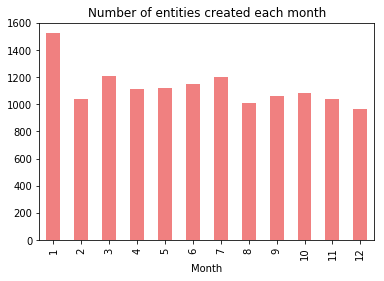

In [ ]:
creation_per_month.index = pd.MultiIndex.from_tuples(creation_per_month.index, names=('month', 'year'))
month_avg_month = creation_per_month.mean(level = 0)
month_avg_month.plot.bar(colors=['lightcoral'])
plt.title('Number of entities created each month')
plt.xlabel('Month')
plt.savefig('Plots/1.Months.png')

### How many entities are there in total each month?

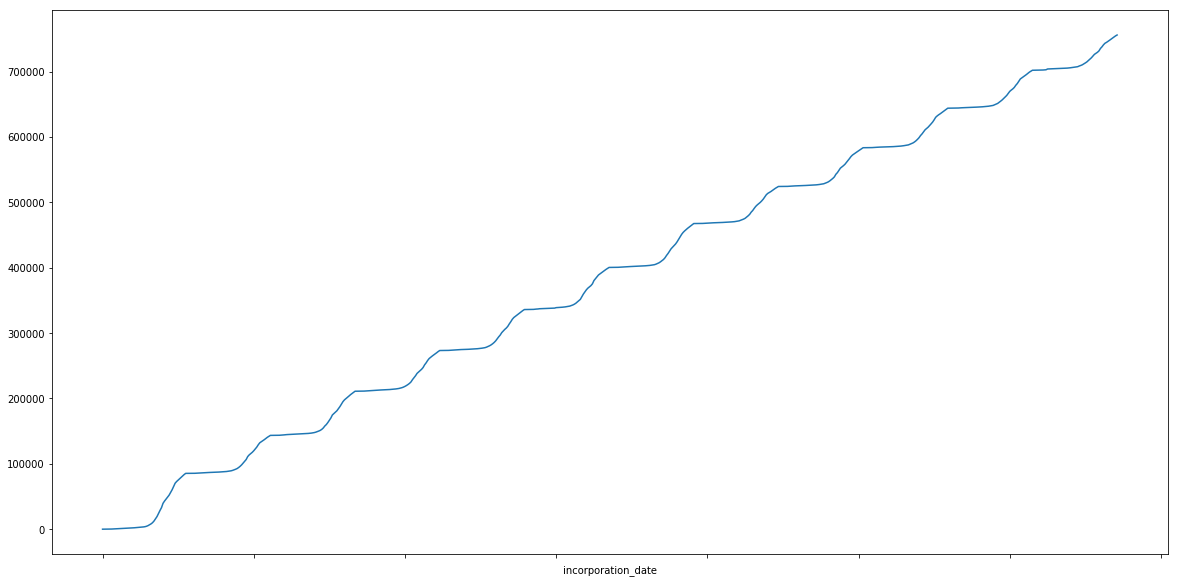

In [ ]:
total_per_month.plot(figsize=(20,10))

### How many entities are created each year?

In [ ]:
entity_dates['incorporation_date'] = entity_dates['incorporation_date'].apply(lambda x: x[1])
creation_per_year = entity_dates.groupby('incorporation_date').size()
total_per_year = creation_per_year.cumsum()

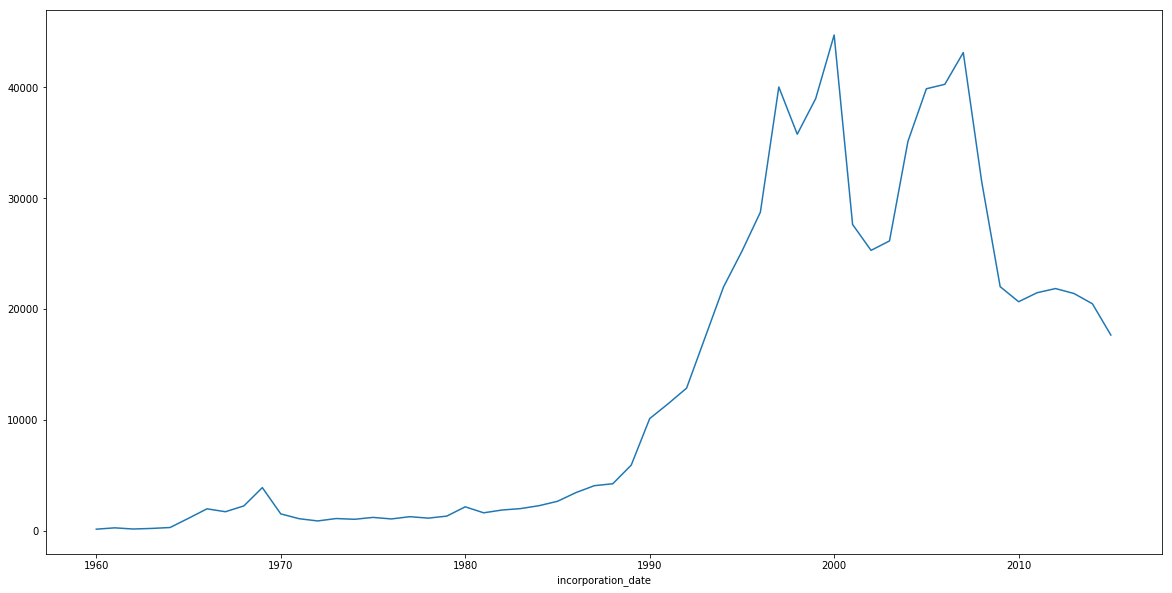

In [ ]:
creation_per_year.plot(figsize=(20,10))

### How many entities in total are there each year?

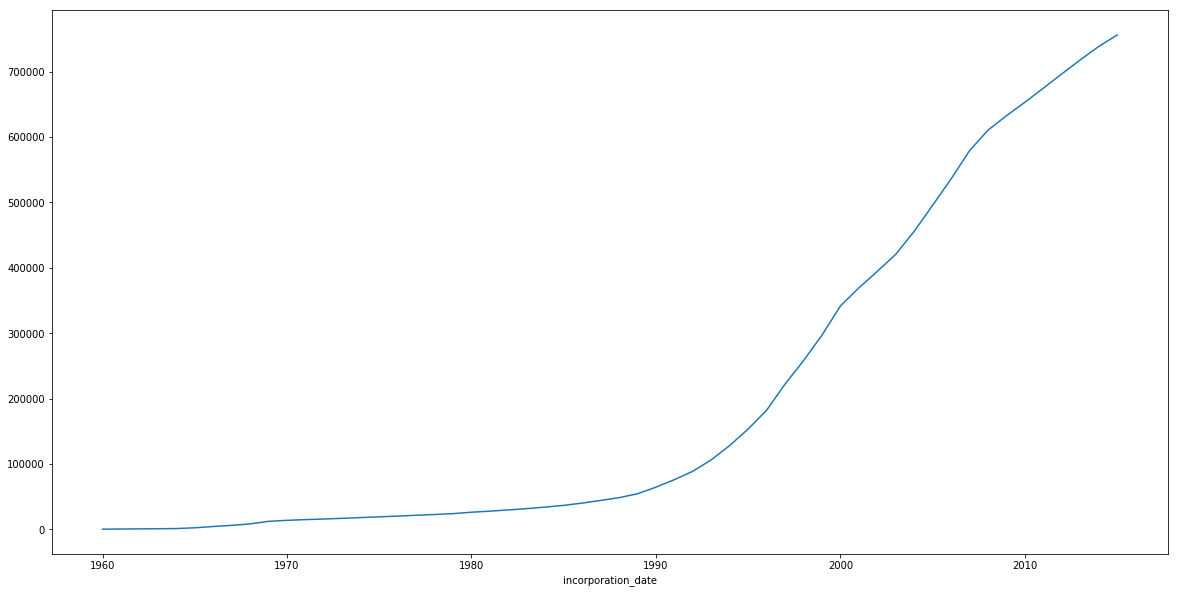

In [ ]:
total_per_year.plot(figsize=(20,10))

### How many edges are created each month?

In [ ]:
def fill_month_year(df):
    temp_edges = df.to_dict()
    for i in range(1960,2016):
        for j in range(1,13):
            if (j,i) not in temp_edges:
                temp_edges[(j,i)] = 0
    return pd.Series(temp_edges).sort_index()

start_date
(1, 1962)        1
(1, 1965)        7
(1, 1966)        4
(1, 1967)        7
(1, 1968)       18
(1, 1969)       11
(1, 1970)        3
(1, 1971)        3
(1, 1972)        6
(1, 1973)        9
(1, 1974)       12
(1, 1975)       18
(1, 1976)       18
(1, 1977)       21
(1, 1978)       29
(1, 1979)       47
(1, 1980)       69
(1, 1981)       39
(1, 1982)       57
(1, 1983)       53
(1, 1984)       94
(1, 1985)      164
(1, 1986)      188
(1, 1987)      266
(1, 1988)      248
(1, 1989)      407
(1, 1990)      499
(1, 1991)      460
(1, 1992)      551
(1, 1993)      592
              ... 
(12, 1986)    1792
(12, 1987)     266
(12, 1988)     311
(12, 1989)     381
(12, 1990)     485
(12, 1991)     452
(12, 1992)     743
(12, 1993)     888
(12, 1994)     981
(12, 1995)    1314
(12, 1996)    3915
(12, 1997)    3766
(12, 1998)    2391
(12, 1999)    3234
(12, 2000)    2915
(12, 2001)    3221
(12, 2002)    3512
(12, 2003)    3934
(12, 2004)    6280
(12, 2005)    6085
(12, 2006)    6478
(

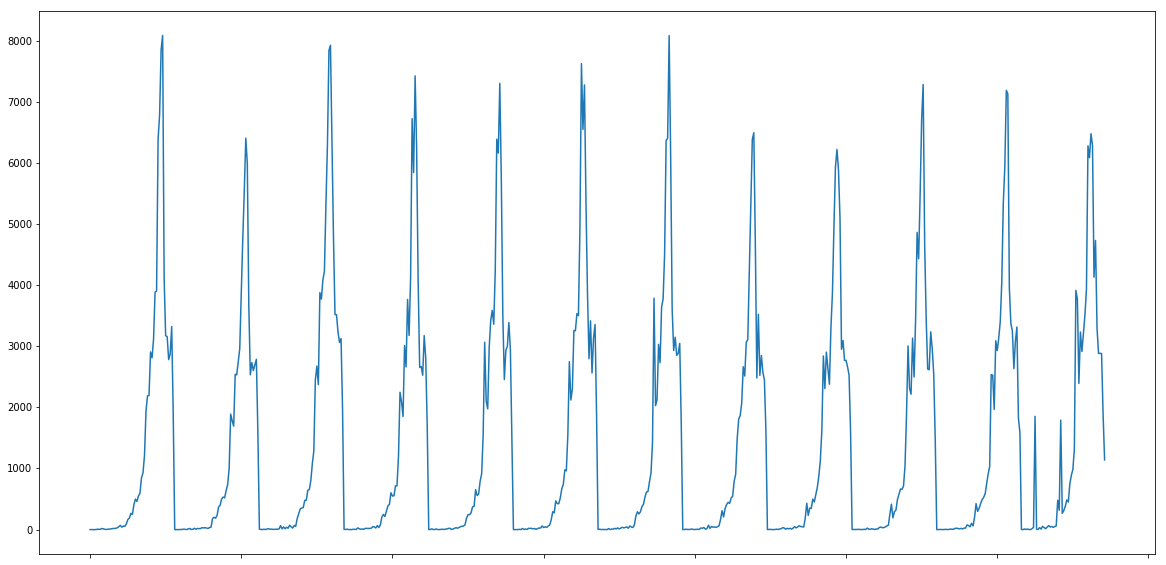

In [ ]:
edges_date = edges_completed[edges_completed['start_date'].notna()]
edges_date['start_date'] = edges_date['start_date'].apply(lambda x: (x.month,x.year))
start_date  = edges_date.groupby('start_date').size()
print(start_date)

start_date = fill_month_year(start_date)
start_date.plot(figsize=(20,10))

### How many edges are deleted each month?

In [ ]:
edges_date = edges_completed[edges_completed['end_date'].notna()]
edges_date['end_date'] = edges_date['end_date'].apply(lambda x: (x.month,x.year))
end_date = edges_date.groupby('end_date').size()
end_date = fill_month_year(end_date)
end_date.plot(figsize=(20,10))

### How many edges in total are there each month?

In [ ]:
creation_deletion = start_date.subtract(end_date)
edges_month_sum = creation_deletion.cumsum()

In [ ]:
edges_month_sum.plot(figsize=(20,10))

### How many edges are created each year?

In [ ]:
def fill_year(df):
    temp_edges = df.to_dict()
    for i in range(1960,2016):
        if i not in temp_edges:
            temp_edges[i] = 0
    return pd.Series(temp_edges).sort_index()

In [ ]:
edges_date = edges_completed[edges_completed['start_date'].notna()]
edges_date['start_date'] = edges_date['start_date'].apply(lambda x: x.year)
start_date  = edges_date.groupby('start_date').size()
start_date.plot(figsize=(20,10))

### How many edges are deleted each year?

In [ ]:
edges_date = edges_completed[edges_completed['end_date'].notna()]
edges_date['end_date'] = edges_date['end_date'].apply(lambda x: x.year)
end_date = edges_date.groupby('end_date').size()
end_date = fill_year(end_date)
end_date.plot(figsize=(20,10))

### How many edges in total are there each year?

In [ ]:
creation_deletion = start_date.subtract(end_date)
edges_year_sum = creation_deletion.cumsum()

In [ ]:
edges_year_sum.plot(figsize=(20,10))

# Final Plots

In [ ]:
creation_per_year.plot(color='gold')
plt.title('Number of offshore societies created each year')
plt.xlabel('Date (year)')

plt.savefig('Plots/1-1.png')

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

start_date.plot(ax=ax1, color='lightskyblue')
ax1.set_title('Number of connections made each year')
ax1.set_xlabel('Date (year)')
end_date.plot(ax=ax2, color='yellowgreen')
ax2.set_title('Number of connections ended each year')
ax2.set_xlabel('Date (year)')

fig.savefig('Plots/1-2.png')

In [ ]:
fig = edges_year_sum.plot(figsize=(10,5), color='lightcoral')
fig.set_title('Evolution of the number of connections over the years')
fig.set_xlabel('Date (year)')

plt.savefig('Plots/1-3.png')

# 2) Do people that are related to one offshore account tend to be related to many more? In other words, is it more likely to have another account once you already have one, than it is to have at least one account?

Below are some custom made functions to make nice plots

In [ ]:
threshold_pourcentage = 0.05

def my_autopct(pct):
    """
    Only print pct if it is more than threshold
    """
    return ('%1.1f%%' % pct) if pct > 100*threshold_pourcentage else ''

def my_labels(serie):
    """
    Label is the jurisdiction name except if it's lower than threshold then it's ''
    """
    total = serie.sum().values[0]
    return [code_to_descriptions[row[0]] if row[1].values/total > 0.05 else '' for row in serie.iterrows()]

In [ ]:
def histedges_equalN(x, nbin):
    """
        To build bins of equal height (the length will vary)
    """
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin + 1),
                     np.arange(npt),
                     np.sort(x))

We can see officer are related to entites are always the START_ID of the edge relationships. This is why to study them we filter on edge going from *officer* to *entity*.

In [ ]:
edges_officer_to_entity = edges_completed[mask_officer_to_entity]
entities_per_officer = edges_officer_to_entity['START_ID'].value_counts()

plt.xlim(1, 15)
plt.ylim(0.7, 1)
#plt.xscale('log')
plt.hist(entities_per_officer, bins=[1, 2, 10, 100, 1000, 10000, 100000], cumulative = True, density=True)

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.hist(entities_per_officer.values, bins = 2000, log=True, color='lightcoral')
plt.title('Number of officers connected to a certain number of offshore societies')
plt.plot()
plt.xlim(0,2000)
plt.ylabel('# of officers(log scale)')
plt.xlabel('# offshore societies')
fig.savefig('Plots/2-1.png')

In [ ]:
total_officers = len(entities_per_officer)

pourcentage_one_account = len(entities_per_officer[entities_per_officer == 1]) / total_officers * 100
pourcentage_two_account = len(entities_per_officer[entities_per_officer <= 2]) / total_officers * 100
pourcentage_ten_account = len(entities_per_officer[entities_per_officer <= 10]) / total_officers * 100


print(entities_per_officer.mean())
print('%.2f%% of officer are related to only one account' % pourcentage_one_account)
print('%.2f%% of officer are related to two or less account' % pourcentage_two_account)
print('%.2f%% of officer are related to ten or less account' % pourcentage_ten_account)

In [ ]:
cat0 = entities_per_officer.values
cat1 = entities_per_officer[entities_per_officer == 1].values
cat2 = entities_per_officer[(entities_per_officer > 1) & (entities_per_officer < 5)].values
cat3 = entities_per_officer[(entities_per_officer >= 5) & (entities_per_officer < 10)].values
cat4 = entities_per_officer[entities_per_officer >= 10].values

categories = [len(cat1), len(cat2), len(cat3), len(cat4)]
#fig, (ax1, ax2) = plt.subplots(2)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17,5))
#plt.subplots_adjust(wspace=0, hspace=0)
#-----
index = range(len(categories))
bar_width = 0.35
rects = ax1.bar(index, categories, color=['lightcoral','gold', 'lightskyblue', 'yellowgreen'])

labels = categories

low = min(categories)
high = max(categories)

for i in range(len(categories)):
    ax1.text(x = index[i]-0.1, y = categories[i]+0.025*(high-low), s = labels[i], size = 9)

ax1.set_title('Number of officers in each category')
ax1.set_xticks(index)
ax1.set_xticklabels(('1 entity', '2 to 4 entities', '5 to 9 entities', '> 10 entities'))
ax1.set_ylim([0, high+0.1*(high-low)])

#-------

sizes = [len(cat1), len(cat2), len(cat3), len(cat4)]
labels = '1 entity', '2 to 4 entities', '5 to 9 entities', '> 10 entities'
colors = ['lightcoral','gold', 'lightskyblue', 'yellowgreen']
ax2.pie(sizes, labels=labels, colors=colors, explode=(0.05, 0.05, 0.05, 0.05), autopct='%1.1f%%', shadow=True, startangle=140)
#plt.axis('equal')
#ax2.set_title('prop. # entities per officer', pad=10)

#-------

sizes = [len(cat2), len(cat3), len(cat4)]
labels = '2 to 4 entities', '5 to 9 entities', '> 10 entities'
colors = ['gold', 'lightskyblue', 'yellowgreen']
#explode = (0.1, 0, 0, 0)
ax3.pie(sizes, labels=labels, colors=colors, explode=(0.05, 0.05, 0.05), autopct='%1.1f%%', shadow=True, startangle=140)
#plt.axis('equal')
#ax3.set_title('prop. # entities per officer', pad=10)

#-------
#fig.set_size_inches(18, 5)
#ax.set_xticklabels(('A', 'B', 'C', 'D'))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=None)
fig.savefig('Plots/2-2.png')

# 3) Do many people share one offshore society or do they tend to have their own?

To answer this question we build a dataframe of connected components to entity. For each entity we gather the IDs of the edges connected to it. Entity is always on the END part of the edge

In [ ]:
nodes_entities = nodes_[nodes_.type == 'entity'].node_id.to_frame()

entities_connections = nodes_entities.merge(edges_completed, how = 'left', left_on='node_id', right_on='END_ID')

- *entities_connections* : contains all the edges that have an entity as an end_type
- *connections_per_entity* : contains the number of connected nodes for each entity

In [ ]:
connections_per_entity = entities_connections.node_id.value_counts()

type_connected_entity = entities_connections.start_type.value_counts()

There are a few entities connected to an entity. They are noted as registered address, and must be outliers

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.hist(connections_per_entity.values, bins = 500, log=True, color='lightcoral')
plt.title('Number of societies having a certain number of connections')
plt.xlabel('# connections')
plt.ylabel('# of societies (log scale)')
plt.xlim(0, 500)
fig.savefig('Plots/3-1.png')

In [ ]:
cat0 = connections_per_entity
cat1 = connections_per_entity[connections_per_entity == 1]
cat2 = connections_per_entity[(connections_per_entity > 1) & (connections_per_entity < 5)]
cat3 = connections_per_entity[(connections_per_entity >= 5) & (connections_per_entity < 10)]
cat4 = connections_per_entity[connections_per_entity >= 10]

categories = [len(cat1), len(cat2), len(cat3), len(cat4)]
#fig, (ax1, ax2) = plt.subplots(2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,5))
#-----
index = range(len(categories))
bar_width = 0.35
rects = ax1.bar(index, categories, color=['lightcoral','gold', 'lightskyblue', 'yellowgreen'])

labels = categories

low = min(categories)
high = max(categories)

for i in range(len(categories)):
    ax1.text(x = index[i]-0.1, y = categories[i]+0.025*(high-low), s = labels[i], size = 9)

ax1.set_title('Number of societies in each category')
ax1.set_xticks(index)
ax1.set_xticklabels(('1 connection', '2 to 4 connections', '5 to 9 connections', '> 10 connections'))
ax1.set_ylim([0, high+0.1*(high-low)])

#-------

sizes = [len(cat1), len(cat2), len(cat3), len(cat4)]
labels = '1 connection', '2 to 4 connections', '5 to 9 connections', '> 10 connections'
colors = ['lightcoral','gold', 'lightskyblue', 'yellowgreen']
plt.pie(sizes, labels=labels, explode=(0.05, 0.05, 0.05, 0.05), colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
#ax2.set_title('prop. # connections per entity', pad=20)

#-------
fig.set_size_inches(18, 5)
fig.savefig('Plots/3-2.png')
#ax.set_xticklabels(('A', 'B', 'C', 'D'))

# 4) How does the proportion of intermediaries depend on the category of company (number of connections) ?

*count_type_entities* : maps each entity to the count of connections of each type (officer / intermediary)

In [ ]:
map_columns = {'END_ID': 'entity' , 'start_type': 'type_connected' , 'START_ID':'id_connected'}

count_type_entities = entities_connections[['END_ID', 'start_type', 'START_ID']]\
                                .rename(columns=map_columns)\
                                .groupby(['entity','type_connected']).count()

"""
count_type_entities = count_type_entities.join(count_type_entities.reset_index() \
                                              .drop(columns='type_connected') \
                                              .rename(columns={'count':'total'})\
                                              .groupby('entity').sum(), how='left')

count_type_entities['proportion'] = count_type_entities['count']/count_type_entities['total']

""" # Optional 

count_type_entities = count_type_entities.reset_index()
count_type_entities = count_type_entities[count_type_entities['type_connected'] != 'entity']

**Make a study on the different categories of companies based on the number of connections : [1], [2-4], [5-9], [10+]**

In [ ]:
all_distrib = count_type_entities.drop(columns='entity').groupby('type_connected').sum()

cat1_distrib = count_type_entities[count_type_entities.entity.isin(cat1.index.values)]\
.drop(columns='entity').groupby('type_connected').sum()

cat2_distrib = count_type_entities[count_type_entities.entity.isin(cat2.index.values)]\
.drop(columns='entity').groupby('type_connected').sum()

cat3_distrib = count_type_entities[count_type_entities.entity.isin(cat3.index.values)]\
.drop(columns='entity').groupby('type_connected').sum()

cat4_distrib = count_type_entities[count_type_entities.entity.isin(cat4.index.values)]\
.drop(columns='entity').groupby('type_connected').sum()

In [ ]:
plt.figure()
plt.title('All entities')
plt.pie(all_distrib, labels=all_distrib.index.values, explode=(0.05, 0.05), colors=['lightcoral', 'gold'], autopct='%1.1f%%', startangle=140, shadow=True)
plt.savefig("Q4_all_distrib")

plt.figure(figsize=(20, 10))
plt.subplot(1, 4, 1)
plt.title('Entities with 1 connection')
plt.pie(cat1_distrib, labels=cat1_distrib.index.values, explode=(0.05, 0.05), colors=['lightcoral', 'gold'], autopct='%1.1f%%', startangle=140, shadow=True)

plt.subplot(1, 4, 2)
plt.title('Entites with 2 to 4 connections')
plt.pie(cat2_distrib, labels=cat2_distrib.index.values, explode=(0.05, 0.05), colors=['lightcoral', 'gold'], autopct='%1.1f%%', startangle=140, shadow=True)

plt.subplot(1, 4, 3)
plt.title('Entites with 5 to 9 connections')
plt.pie(cat3_distrib, labels=cat3_distrib.index.values, explode=(0.05, 0.05), colors=['lightcoral', 'gold'], autopct='%1.1f%%', startangle=140, shadow=True)

plt.subplot(1, 4, 4)
plt.title('Entites with >10 connections')
plt.pie(cat4_distrib, labels=cat4_distrib.index.values, explode=(0.05, 0.05), colors=['lightcoral', 'gold'], autopct='%1.1f%%', startangle=140, shadow=True)
plt.savefig("Q4_distribs")
plt.plot()

Intermediary are essential for a offshore companies, they at least need one to communicate with. But having more people in the company doesn't mean you need more intermediaries to do the work. Intermediaries must therefore have a lot of work when connected to a big company.

In [ ]:
print(pourcentage(len(nodes_[nodes_.type == 'intermediary']) / len(nodes_)), "of nodes are intermediary")
intermediaries_in_edges = edges_completed[(edges_completed.start_type == 'intermediary') | (edges_completed.end_type == 'intermediary')]
print(pourcentage(len(intermediaries_in_edges)/len(edges_completed)), 'of edges have an intermediary in them')

It is now interesting to see if intermediaries connected to big companies are connected to less companies in number. In other words : if you're an intermediary of a big company do you only take care of this one ?

In [ ]:
q4 = entities_connections[['END_ID', 'start_type', 'START_ID']].rename(columns=map_columns)
q4 = q4[q4.type_connected != 'entity']

q4 = q4.join(q4.groupby('entity').count().id_connected, on = 'entity', rsuffix= '_count')

mask_int_q4 = (q4.type_connected == 'intermediary')

cat1_intermediaries = q4[(q4.id_connected_count == 1) & mask_int_q4].id_connected
cat2_intermediaries = q4[(q4.id_connected_count >= 2) & (q4.id_connected_count <= 4) & mask_int_q4].id_connected
cat3_intermediaries = q4[(q4.id_connected_count >= 5) & (q4.id_connected_count <= 9) & mask_int_q4].id_connected
cat4_intermediaries = q4[(q4.id_connected_count >= 10) & mask_int_q4].id_connected

entities_per_int = q4[mask_int_q4][['id_connected', 'entity']].groupby('id_connected').count().reset_index()

cat1_intermediaries_count = entities_per_int[entities_per_int.id_connected.isin(cat1_intermediaries)]
cat2_intermediaries_count = entities_per_int[entities_per_int.id_connected.isin(cat2_intermediaries)]
cat3_intermediaries_count = entities_per_int[entities_per_int.id_connected.isin(cat3_intermediaries)]
cat4_intermediaries_count = entities_per_int[entities_per_int.id_connected.isin(cat4_intermediaries)]

In [ ]:
print("On average an intermediary is connected to %.1f entities" % entities_per_int['entity'].mean())
print("On average an intermediary that is at least connected to an entity of category :")
print("- [1] is connected tois connected to %.1f entities" % cat1_intermediaries_count['entity'].mean())
print("- [2-4] is connected to %.1f entities" % cat2_intermediaries_count['entity'].mean())
print("- [5-9] is connected to %.1f entities" % cat3_intermediaries_count['entity'].mean())
print("- [10+] is connected to %.1f entities" % cat4_intermediaries_count['entity'].mean())

In [ ]:
print("The median number of connection per intermediary is %.1f" % entities_per_int['entity'].mean())
print("The median number of an intermediary at least connected to an entity of category :")
print("- [1] is %.1f" % cat1_intermediaries_count['entity'].median())
print("- [2-4] is %.1f" % cat2_intermediaries_count['entity'].median())
print("- [5-9] is %.1f" % cat3_intermediaries_count['entity'].median())
print("- [10+] is %.1f" % cat4_intermediaries_count['entity'].median())

In [ ]:
labels = ['All', 'Cat1', 'Cat2', 'Cat3', 'Cat4']
data_boxplot = [entities_per_int['entity'], cat1_intermediaries_count['entity'],\
                cat2_intermediaries_count['entity'],\
                cat3_intermediaries_count['entity'], cat4_intermediaries_count['entity']]
plt.boxplot(data_boxplot, labels=labels, sym='', showmeans=True, meanline=True)
plt.ylim(1, 83)
plt.plot()

Clearly the mean is being pulled very high because of some extreme values, let's look at them and see statistics without them

In [ ]:
i=0
upper_bound = 2000
for v in data_boxplot[4]:
    if v > upper_bound:
        i+=1
print(i, "values are higher than", upper_bound)

In [ ]:
data_boxplot_cleaned = []
for array_values in data_boxplot:
    data_boxplot_cleaned.append(list())
    for v in array_values:
        if v <= upper_bound:
            data_boxplot_cleaned[-1].append(v)

In [ ]:
plt.boxplot(data_boxplot_cleaned, labels=labels, sym='', showmeans=True,meanline=True)
plt.ylim(1, 50)
plt.title('Number of connections per intermediary depending on category')
plt.savefig('Q4_boxplot')
plt.plot()

**Note :** It might sound weird that each one of these averages are all higher individually than the global average.

But it actually tells us that intermediaries with many connections have clients (entities) in all of the categories ! So this actually means that the more connections you have as an intermediary, the more diverse they will be.

This is the opposite of what we predicted, the bigger entities you intermediate for, the more entities you are connected to. This probably means that some people or groups of people are notorious intermediaries and are therefore working for many entities.

# 5) Is there a correlation between the location of the people and the location of their offshore society?

## Flatten country codes with multiple countries separated by a coma

Some nodes are related to many countries. This can be the case of big multi-national companies, and their code is written in the form "AAA;BBB;...;ZZZ". Here we flatten these values, by create one row for each nationality of each node. This decision is arguable, since it gives the same weight to 10 different nodes as it gives for one node with 10 different nationalities. But since we do this for multi-national companies, we consider they can have many subsidiaries and this is relevant 

In [ ]:
edges_diff_start_end_address = edges_completed[mask_country_notna & mask_diff_start_end_address]\
.end_type.value_counts()

In [ ]:
edges_q5 = edges_completed[mask_officer_to_entity & mask_start_loc_notna & mask_end_loc_notna][['start_country', 'end_jurisdiction']]
edges_q5['sum'] = 1
edges_q5.start_country = edges_q5.start_country.str.split(';')

In [ ]:
flattened_country = []

for index, row in edges_q5[(edges_q5.start_country.map(len) > 1)].iterrows():
    for country in row['start_country']:
        modified_row = row.copy()
        modified_row['start_country'] = country #+ '_GRP'
        flattened_country.append(modified_row)

edges_q5_flattened = edges_q5[edges_q5['start_country'].map(len) == 1]
edges_q5_flattened.start_country = edges_q5_flattened.start_country.apply(lambda arr: arr[0])
edges_q5_flattened = edges_q5_flattened.append(flattened_country)
      
print(len(edges_q5), "edges when you don't flatten the country codes")
print(len(edges_q5_flattened), "edges when you flatten the country codes")

In [ ]:
edges_q5_flattened

In [ ]:
q5_distrib = edges_q5_flattened.groupby(['start_country', 'end_jurisdiction']).sum()

## Q5 Pie printing

In [ ]:
threshold_pourcentage = 0.05

def my_autopct(pct):
    """
    Only print pct if it is more than threshold
    """
    return ('%1.1f%%' % pct) if pct > 100*threshold_pourcentage else ''

def my_labels(serie):
    """
    Label is the jurisdiction name except if it's lower than threshold then it's ''
    """
    total = serie.sum().values[0]
    return [row[0] if row[1].values/total > 0.05 else '' for row in serie.iterrows()]

In [ ]:
q5_distrib

In [ ]:
one_pie = q5_distrib.xs('USA', level='start_country').sort_values('sum', ascending = False)
labels = my_labels(one_pie)

plt.pie(one_pie, radius = 2, labels=labels, autopct=my_autopct, startangle=90, shadow = True)
plt.show()

## Q5 Scatter

In [ ]:
q5_distrib_country = q5_distrib.groupby('start_country').sum()
q5_distrib_country = q5_distrib.join(q5_distrib_country, how = 'left', on = 'start_country', rsuffix = '_country')
q5_distrib_country['pourcentage'] = q5_distrib_country['sum']/q5_distrib_country['sum_country']
q5_distrib_country.groupby('start_country').count()

In [ ]:
threshold_scatter_pourc = 0.1
threshold_scatter_countries = 10000

threshold_mask = (q5_distrib_country['pourcentage'] > threshold_scatter_pourc) \
& (q5_distrib_country['sum_country'] > threshold_scatter_countries)

q5_thresholded = q5_distrib_country[threshold_mask]

countries_x_scatter =  [val[0] for val in q5_thresholded.index.values]
jurisdictions_y_scatter =  [val[1] for val in q5_thresholded.index.values]
scalars_scatter = q5_thresholded['pourcentage'].values * 100

plt.scatter(countries_x_scatter, jurisdictions_y_scatter, scalars_scatter)
plt.show()

We set thresholds to only print relevant data and not put too much noise in the graphs

In [ ]:
threshold_scatter_pourc = 0.05
threshold_scatter_countries = 10000

threshold_mask = (q5_distrib_country['pourcentage'] > threshold_scatter_pourc) \
& (q5_distrib_country['sum_country'] > threshold_scatter_countries)

q5_thresholded = q5_distrib_country[threshold_mask]

countries_x_scatter =  [val[0] for val in q5_thresholded.index.values]
jurisdictions_y_scatter =  [code_to_descriptions[val[1]] for val in q5_thresholded.index.values]
scalars_scatter = q5_thresholded['pourcentage'].values * 100

plt.figure(figsize=(15,6))
plt.scatter(countries_x_scatter, jurisdictions_y_scatter, scalars_scatter, color=['lightcoral'])
plt.title('Correlation between the location of the people and the location of their offshore society')
plt.xlabel('Origin of the Officer')
plt.ylabel('Location of the Offshore Society')
plt.xticks(rotation='vertical')
plt.savefig('Plots/5-1.png')
plt.show()

We can clearly see Malta and the British Virgin Islands as constant prefered choice whatever the country of origin of the officer.

### UP cell : now plot distribution for each country and see if there is always a leader, what is the variance, %of total for top1, BUILD MAP Where you can click on a country and see the distribution

In [ ]:
edges_completed[(edges_completed['start_jurisdiction'] != edges_completed['end_jurisdiction']) \
               & (edges_completed['start_jurisdiction'].notna()) & ((edges_completed['end_jurisdiction'].notna()))]\
.TYPE.value_counts()

## Plot map for 10 biggest countries¶

In [ ]:
def compute_center(code, coord):
    if code == 'USA':
        return 38.36320700, -101.989278
    if code == 'CAN':
        return 56.09433049, -101.989278
    if code == 'RUS':
        return 63.884226, 92.019764
    if code == 'CHN':
        return 33.477272, 102.210619
    lat = 0
    lon = 0
    count = 0
    for elem in coord:
        lat += elem[0]
        lon += elem[1]
        count += 1
    return [lon/count, lat/count]

In [ ]:
world_data = json.load(open('world.json')) 
for i in range(len(world_data['features'])):
    code = world_data['features'][i]['id']
    name = world_data['features'][i]['properties']['name']
    if name in descriptions_to_code:
        if code != descriptions_to_code[name]:
            world_data['features'][i]['id'] = descriptions_to_code[name]

with open("world.json", "w") as jsonFile:
    json.dump(world_data, jsonFile, indent=4)

In [ ]:
world_data = json.load(open('world.json')) 
code_to_coord = {}
for i in range(len(world_data['features'])):
    code = world_data['features'][i]['id']
    coord = world_data['features'][i]['geometry']['coordinates'][0][0]
    code_to_coord[code] = compute_center(code, coord)

In [ ]:
top_countries = edges_q5_flattened[edges_q5_flattened['start_country'].apply(lambda x: 'GRP' not in x)].groupby('start_country').size().sort_values(ascending = False)
top10 = top_countries[0:11]
top10 = top10.drop('XXX')

In [ ]:
def percentage(df):
    m = df['sum'].sum()
    df['sum'] = df['sum'].apply(lambda x: x*100 / m)
    return df

In [ ]:
def stylefunction(feature,df):
    return {
        'fillOpacity': 0,
        'weight': 0,
        'fillColor': 'blue'
    }

In [ ]:
world = folium.Map([2,30], tiles='OpenStreetMap', zoom_start = 2.3)
world_data = json.load(open('world.json'))  
list_countries = top10.index
for code in code_to_coord:
    if code in list_countries and code in code_to_descriptions:
        coord = code_to_coord[code]
        df = percentage(q5_distrib.xs(code, level='start_country'))
        arrows = {}
        weights = {}
        for c in df.index:
            temp_c = c
            if c in ['NEV','US','WYO']:
                temp_c = 'USA'
            if code != c:
                if c in code_to_coord:
                    arrows[temp_c] = code_to_coord[temp_c]
                    weights[temp_c] = min(10,df.xs(c)['sum']/2)

        marker = folium.Marker(location=coord, icon = folium.Icon(color='red'), popup=code_to_descriptions[code])
        layer = folium.GeoJson(world_data,
                   name=code_to_descriptions[code],
                   style_function = lambda x : stylefunction(x,df.to_dict()['sum'])
                      ).add_child(marker)

        for c in arrows:
            if c in code_to_descriptions:
                line = folium.PolyLine([coord,arrows[c]],weight=max(0.5,weights[c]))
                marker_end = folium.Marker(location=arrows[c], popup=code_to_descriptions[c])
                layer.add_child(marker_end)
                layer.add_child(line)

        layer.add_to(world)
    
folium.LayerControl().add_to(world)
world.save('biggest.html')
world

## Plot map with markers

In [ ]:
def compute_pie_chart(code):
    one_pie = q5_distrib.xs(code, level='start_country').sort_values('sum', ascending = False)
    labels = my_labels(one_pie)
    fig = plt.figure(figsize=(5,3))
    colors = ['lightcoral','gold', 'lightskyblue', 'yellowgreen', 'violet', 'lightgray', 'palegreen', 'pink']
    plt.pie(one_pie, labels=labels, colors=colors, autopct=my_autopct, startangle=90, shadow = True)
    plt.title(code_to_descriptions[code], fontsize=12, fontweight="bold", pad=5)
    png = 'pie_{}.png'.format(code)
    plt.savefig('figures/'+png, dpi=75)
    plt.close(fig)

In [ ]:
top100 = top_countries[0:101]
top100 = top100.drop('XXX')

In [ ]:
world_data = json.load(open('world.json'))

world = folium.Map([2,30], tiles='OpenStreetMap', zoom_start = 2.3)

for i in range(len(world_data['features'])):
    code = world_data['features'][i]['id']
    coord = world_data['features'][i]['geometry']['coordinates'][0][0]
    if code in top100:
        compute_pie_chart(code)
        
        png = 'figures/pie_{}.png'.format(code)
        encoded = base64.b64encode(open(png, 'rb').read()).decode()
    
        html = '<img src="data:image/png;base64,{}">'.format
        iframe = IFrame(html(encoded), width=400, height=200)
        popup = folium.Popup(iframe, max_width=2650)
    
        folium.Marker(location=compute_center(code,coord), popup=popup).add_to(world)

world.save('markers.html')
world

In [ ]:
dis = nodes_.type.value_counts()
fig = plt.figure(figsize=(5,5))
plt.pie(dis, labels=dis.index, explode=(0.05, 0.05, 0.05, 0.05), colors=['lightcoral', 'gold', 'lightskyblue', 'yellowgreen'], autopct='%1.1f%%', startangle=140, shadow=True)
plt.title('Nodes\' types distribution', pad=10)
plt.savefig('Plots/0.png')

In [ ]:
code_to_descriptions